# Sistem za preporuku filmova 

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import ipywidgets as widgets
from IPython.display import clear_output
from sklearn.metrics import r2_score
import random 
import statistics

In [2]:
#Ucitavanje podataka
movies = pd.read_csv('movies.csv', sep=',', error_bad_lines=False, encoding="latin-1")
movies.columns = ['MovieID', 'TitleAndYearOfPublication', 'Genres']
movies.head()

,MovieID,TitleAndYearOfPublication,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('ratings.csv', sep=',', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
tags = pd.read_csv('tags.csv', sep=',', error_bad_lines=False, encoding="latin-1")
tags.columns = ['UserID', 'MovieID', 'Tag', 'Timestamp']
tags.head()

,UserID,MovieID,Tag,Timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Preprocesiranje podataka

In [5]:
#Provera oblika skupa podataka
print (movies.shape)
print (ratings.shape)
print (tags.shape)

(9742, 3)
(100836, 4)
(3683, 4)


In [6]:
# Print the number of records and the total number of movies
print('Dataset sadrzi ', len(ratings), ' ocena za ', len(movies), ' filmova.')

Dataset sadrzi  100836  ocena za  9742  filmova.


### Preprocesiranje datoteke movies

In [7]:
# datoteka movies
movies.head()

,MovieID,TitleAndYearOfPublication,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# Provera tipova podataka kolona
movies.dtypes

MovieID                       int64
TitleAndYearOfPublication    object
Genres                       object
dtype: object

In [9]:
# Analiza kolone 'TitleAndYearOfPublication
movies.loc[movies.TitleAndYearOfPublication.isnull(),:]
#nema redova za koje nije naveden titl

,MovieID,TitleAndYearOfPublication,Genres


In [10]:
np.array(movies.TitleAndYearOfPublication)

array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'Flint (2017)', 'Bungo Stray Dogs: Dead Apple (2018)',
       'Andrew Dice Clay: Dice Rules (1991)'], dtype=object)

In [11]:
for i in range (0, movies.TitleAndYearOfPublication.size):
    titleAndYearOfPublication = movies.TitleAndYearOfPublication[i].split('(')

    movies.loc[(movies.index == i), 'Title'] = titleAndYearOfPublication[0]

    if (len(titleAndYearOfPublication) > 1):
        yearOfPublication = titleAndYearOfPublication[len(titleAndYearOfPublication)-1]
        yearOfPublication = yearOfPublication.split(')')[0]
    else:
        yearOfPublication = 0
    movies.loc[(movies.index == i), 'YearOfPublication'] = yearOfPublication

In [12]:
movies.head()

,MovieID,TitleAndYearOfPublication,Genres,Title,YearOfPublication
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


In [13]:
movies['YearOfPublication'] = movies['YearOfPublication'].astype(np.int32)

In [14]:
movies.dtypes

MovieID                       int64
TitleAndYearOfPublication    object
Genres                       object
Title                        object
YearOfPublication             int32
dtype: object

In [15]:
print (sorted(movies['YearOfPublication'].unique()))

[0, 1902, 1903, 1908, 1915, 1916, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [16]:
# Vrednost 0 nije validna 
# Postavljamo nevalidne vrednosti na NaN
movies.loc[(movies.YearOfPublication == 0),'YearOfPublication'] = np.NAN

In [17]:
movies.YearOfPublication.isnull().sum()
#12 null vrednosti

12

In [18]:
# proveravamo koji filmovi nemaju godinu publikaciju
movies.loc[movies.YearOfPublication.isnull(),:]
#12 NaNs

,MovieID,TitleAndYearOfPublication,Genres,Title,YearOfPublication
6059,40697,Babylon 5,Sci-Fi,Babylon 5,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN
9091,143410,Hyena Road,(no genres listed),Hyena Road,NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),The Adventures of Sherlock Holmes and Doctor W...,NaN
9179,149334,Nocturnal Animals,Drama|Thriller,Nocturnal Animals,NaN
9259,156605,Paterson,(no genres listed),Paterson,NaN
9367,162414,Moonlight,Drama,Moonlight,NaN
9448,167570,The OA,(no genres listed),The OA,NaN
9514,171495,Cosmos,(no genres listed),Cosmos,NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),Maria Bamford: Old Baby,NaN


In [19]:
# prikaz celog teksta iz kolona, da nemamo ...
pd.set_option('display.max_colwidth', 1)

In [20]:
# proveravamo koji filmovi nemaju godinu publikaciju
movies.loc[movies.YearOfPublication.isnull(),:]
#12 NaNs

,MovieID,TitleAndYearOfPublication,Genres,Title,YearOfPublication
6059,40697,Babylon 5,Sci-Fi,Babylon 5,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN
9091,143410,Hyena Road,(no genres listed),Hyena Road,NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor Watson,(no genres listed),The Adventures of Sherlock Holmes and Doctor Watson,NaN
9179,149334,Nocturnal Animals,Drama|Thriller,Nocturnal Animals,NaN
9259,156605,Paterson,(no genres listed),Paterson,NaN
9367,162414,Moonlight,Drama,Moonlight,NaN
9448,167570,The OA,(no genres listed),The OA,NaN
9514,171495,Cosmos,(no genres listed),Cosmos,NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),Maria Bamford: Old Baby,NaN


In [21]:
# Googlanjem nalazimo nedostajuce YearOfPublications
movies.loc[(movies.TitleAndYearOfPublication == 'Babylon 5'),'YearOfPublication'] = 1998
movies.loc[(movies.TitleAndYearOfPublication == 'Ready Player One'),'YearOfPublication'] = 2018
movies.loc[(movies.TitleAndYearOfPublication == 'Hyena Road'),'YearOfPublication'] = 2015
movies.loc[(movies.TitleAndYearOfPublication == 'The Adventures of Sherlock Holmes and Doctor Watson'),'YearOfPublication'] = 1981
movies.loc[(movies.TitleAndYearOfPublication == 'Nocturnal Animals'),'YearOfPublication'] = 2016
movies.loc[(movies.TitleAndYearOfPublication == 'Paterson'),'YearOfPublication'] = 2016
movies.loc[(movies.TitleAndYearOfPublication == 'Moonlight'),'YearOfPublication'] = 2016
movies.loc[(movies.TitleAndYearOfPublication == 'The OA'),'YearOfPublication'] = 2019
movies.loc[(movies.TitleAndYearOfPublication == 'Cosmos'),'YearOfPublication'] = 1980
movies.loc[(movies.TitleAndYearOfPublication == 'Maria Bamford: Old Baby'),'YearOfPublication'] = 2017
movies.loc[(movies.TitleAndYearOfPublication == 'Generation Iron 2'),'YearOfPublication'] = 2017
movies.loc[(movies.TitleAndYearOfPublication == 'Black Mirror'),'YearOfPublication'] = 2011

In [22]:
# Ponovo proveravamo
movies.YearOfPublication.isnull().sum()
#no NaNs

0

In [23]:
print (movies.loc[movies.Genres == '(no genres listed)', 'TitleAndYearOfPublication'])

8517    La cravate (1957)                                                                 
8684    Ben-hur (2016)                                                                    
8687    Pirates of the Caribbean: Dead Men Tell No Tales (2017)                           
8782    Superfast! (2015)                                                                 
8836    Let It Be Me (1995)                                                               
8902    Trevor Noah: African American (2013)                                              
9033    Guardians (2016)                                                                  
9053    Green Room (2015)                                                                 
9070    The Brand New Testament (2015)                                                    
9091    Hyena Road                                                                        
9138    The Adventures of Sherlock Holmes and Doctor Watson                               

In [24]:
# googlanjem nalazimo nedostajuce zanrove
movies.loc[(movies.TitleAndYearOfPublication == 'La cravate (1957)'),'Genres'] = 'Short'
movies.loc[(movies.TitleAndYearOfPublication == 'Ben-hur (2016)'),'Genres'] = 'Action|Adventure|Drama'
movies.loc[(movies.TitleAndYearOfPublication == 'Pirates of the Caribbean: Dead Men Tell No Tales (2017)'),'Genres'] = 'Action|Adventure|Fantasy'
movies.loc[(movies.TitleAndYearOfPublication == 'Superfast! (2015)'),'Genres'] = 'Comedy'
movies.loc[(movies.TitleAndYearOfPublication == 'Let It Be Me (1995)'),'Genres'] = 'Drama|Romance'
movies.loc[(movies.TitleAndYearOfPublication == 'Trevor Noah: African American (2013)'),'Genres'] = 'Comedy'
movies.loc[(movies.TitleAndYearOfPublication == 'Guardians (2016)'),'Genres'] = 'Short|Horror'
movies.loc[(movies.TitleAndYearOfPublication == 'Green Room (2015)'),'Genres'] = 'Horror|Thriller'
movies.loc[(movies.TitleAndYearOfPublication == 'The Brand New Testament (2015)'),'Genres'] = 'Comedy|Fantasy'
movies.loc[(movies.TitleAndYearOfPublication == 'Hyena Road'),'Genres'] = 'Action|Drama|War'
movies.loc[(movies.TitleAndYearOfPublication == 'The Adventures of Sherlock Holmes and Doctor Watson'),'Genres'] = 'Crime|Mystery|Romance'
movies.loc[(movies.TitleAndYearOfPublication == 'A Cosmic Christmas (1977)'),'Genres'] = 'Animation|Family|Sci-Fi'
movies.loc[(movies.TitleAndYearOfPublication == 'Grease Live (2016)'),'Genres'] = 'Musical|Romance'
movies.loc[(movies.TitleAndYearOfPublication == 'Noin 7 veljestÃ¤ (1968)'),'Genres'] = 'Comedy'
movies.loc[(movies.TitleAndYearOfPublication == 'Paterson'),'Genres'] = 'Comedy|Drama|Romance'
movies.loc[(movies.TitleAndYearOfPublication == 'Ali Wong: Baby Cobra (2016)'),'Genres'] = 'Comedy'
movies.loc[(movies.TitleAndYearOfPublication == "A Midsummer Night's Dream (2016)"),"Genres"] = "Comedy|Fantasy|Romance"
movies.loc[(movies.TitleAndYearOfPublication == 'The Forbidden Dance (1990)'),'Genres'] = 'Drama|Music|Romance'
movies.loc[(movies.TitleAndYearOfPublication == 'Ethel & Ernest (2016)'),'Genres'] = 'Animation|Drama|History'
movies.loc[(movies.TitleAndYearOfPublication == 'Whiplash (2013)'),'Genres'] = 'Short|Drama|Music'
movies.loc[(movies.TitleAndYearOfPublication == 'The OA'),'Genres'] = 'Drama|Fantasy|Mystery'
movies.loc[(movies.TitleAndYearOfPublication == 'Lemonade (2016)'),'Genres'] = 'Drama'
movies.loc[(movies.TitleAndYearOfPublication == 'Cosmos'),'Genres'] = 'Documentary'
movies.loc[(movies.TitleAndYearOfPublication == 'Maria Bamford: Old Baby'),'Genres'] = 'Documentary|Comedy'
movies.loc[(movies.TitleAndYearOfPublication == 'Death Note: Desu nÃ´to (2007)'),'Genres'] = 'Animation|Crime|Drama'
movies.loc[(movies.TitleAndYearOfPublication == 'Generation Iron 2'),'Genres'] = 'Documentary'
movies.loc[(movies.TitleAndYearOfPublication == 'T2 3-D: Battle Across Time (1996)'),'Genres'] = ' Short|Action|Sci-Fi'
movies.loc[(movies.TitleAndYearOfPublication == 'The Godfather Trilogy: 1972-1990 (1992)'),'Genres'] = 'Crime|Drama'
movies.loc[(movies.TitleAndYearOfPublication == 'The Adventures of Sherlock Holmes and Doctor Watson: The Hunt for the Tiger (1980)'),'Genres'] = 'Crime|Mystery|Romance'
movies.loc[(movies.TitleAndYearOfPublication == 'The Putin Interviews (2017)'),'Genres'] = ' Documentary|Biography'
movies.loc[(movies.TitleAndYearOfPublication == 'Black Mirror'),'Genres'] = ' Drama|Sci-Fi|Thriller '
movies.loc[(movies.TitleAndYearOfPublication == 'Too Funny to Fail: The Life and Death of The Dana Carvey Show (2017)'),'Genres'] = 'Documentary'
movies.loc[(movies.TitleAndYearOfPublication == 'Serving in Silence: The Margarethe Cammermeyer Story (1995)'),'Genres'] = ' Biography|Drama'
movies.loc[(movies.TitleAndYearOfPublication == 'A Christmas Story Live! (2017)'),'Genres'] = 'Musical'

In [25]:
print (movies.loc[movies.Genres == '(no genres listed)', 'TitleAndYearOfPublication'])

Series([], Name: TitleAndYearOfPublication, dtype: object)


In [26]:
for i in range (0, movies.Genres.size):
    genres = movies.Genres[i].split('|')
    for j in range (0, len(genres)):
        columnName = "Genre " + str(j)
        movies.loc[(movies.index == i), columnName] = genres[j]

In [27]:
movies.dtypes

MovieID                      int64  
TitleAndYearOfPublication    object 
Genres                       object 
Title                        object 
YearOfPublication            float64
Genre 0                      object 
Genre 1                      object 
Genre 2                      object 
Genre 3                      object 
Genre 4                      object 
Genre 5                      object 
Genre 6                      object 
Genre 7                      object 
Genre 8                      object 
Genre 9                      object 
dtype: object

In [28]:
movies['YearOfPublication'] = movies['YearOfPublication'].astype(np.int32)

In [29]:
movies.head()

,MovieID,TitleAndYearOfPublication,Genres,Title,YearOfPublication,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# brisanje kolona Title i Genres jer su podeljenje na vise kolona
movies.drop(['TitleAndYearOfPublication', 'Genres'],axis=1,inplace=True)

In [31]:
movies.head()

,MovieID,Title,YearOfPublication,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9
0,1,Toy Story,1995,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,1995,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,1995,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,1995,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,1995,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocesiranje datoteke ratings

In [32]:
# Datoteka ratings 
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [33]:
ratings.dtypes

UserID       int64  
MovieID      int64  
Rating       float64
Timestamp    int64  
dtype: object

In [34]:
print (sorted(ratings['Rating'].unique()))

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Datoteka tags

In [35]:
# Datoteka tags 
tags.head()

,UserID,MovieID,Tag,Timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [36]:
tags.dtypes

UserID       int64 
MovieID      int64 
Tag          object
Timestamp    int64 
dtype: object

## Kraj preprocesiranja

In [37]:
#ratings datoteka bi trebalo da sadrzi samo filmove koji se nalaze u movies datoteci
ratings_new = ratings[ratings.MovieID.isin(movies.MovieID)]

In [38]:
print (ratings.shape)
print (ratings_new.shape)
#Svi rejtinzi se odnose na filmove iz dataseta

(100836, 4)
(100836, 4)


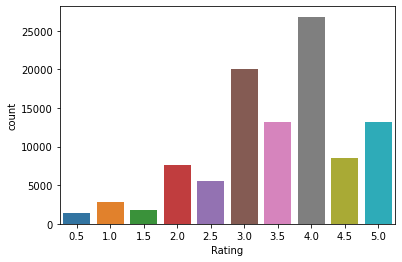

In [39]:
#plotting count za ocene filmova
sns.countplot(data=ratings , x='Rating')
plt.show()
# Vidi se da korisnici cesce daju visoke ocene filmovima. 4 je najcesca ocena

# Jednostavan sistem za preporuku baziran na popularnosti

In [40]:
#At this point , a simple popularity based recommendation system can be built based on count of user ratings for different movies
ratings_count = pd.DataFrame(ratings.groupby(['MovieID'])['Rating'].sum())
top10 = ratings_count.sort_values('Rating', ascending = False).head(10)
print("Following movies are recommended")
top10.merge(movies, left_index = True, right_on = 'MovieID')
#Given below are top 10 recommendations based on popularity.

Following movies are recommended


,Rating,MovieID,Title,YearOfPublication,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9
277,1404.0,318,"Shawshank Redemption, The",1994,Crime,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,1370.0,356,Forrest Gump,1994,Comedy,Drama,Romance,War,NaN,NaN,NaN,NaN,NaN,NaN
257,1288.5,296,Pulp Fiction,1994,Comedy,Crime,Drama,Thriller,NaN,NaN,NaN,NaN,NaN,NaN
1939,1165.5,2571,"Matrix, The",1999,Action,Sci-Fi,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510,1161.0,593,"Silence of the Lambs, The",1991,Crime,Horror,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,1062.0,260,Star Wars: Episode IV - A New Hope,1977,Action,Adventure,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,955.5,110,Braveheart,1995,Action,Drama,War,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2226,931.5,2959,Fight Club,1999,Action,Crime,Drama,Thriller,NaN,NaN,NaN,NaN,NaN,NaN
461,929.5,527,Schindler's List,1993,Drama,War,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,892.5,480,Jurassic Park,1993,Action,Adventure,Sci-Fi,Thriller,NaN,NaN,NaN,NaN,NaN,NaN


## Priprema podataka za kolaborativno filtriranje

In [41]:
# Generisanje ratings matrice iz ratings tabele
ratings_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')
userID = ratings_matrix.index
movieID = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()
# Zapaza se da su najcesce vrednosti NaN, tj. ocene nisu date

(610, 9724)


MovieID,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
UserID,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Posto NaN vrednosti ne mogu da se koriste u algoritmima za treniranje menjamo te vrednosti 0, 
#sto znaci da ne postoji ocena

ratings_matrix.fillna(0, inplace = True)

In [43]:
# Provera prvih 5 redova 
ratings_matrix.head(5)

MovieID,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
UserID,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
test_indices = random.sample(range(610), 100)

In [67]:
with open('test_indices.txt', 'w') as f:
    for item in test_indices:
        f.write("%s\n" % item)
f.close()

# Kolaborativno filtriranje

In [68]:
# podesavanje globalnih promenljivih
global metric,k
k=10
metric='cosine'

In [69]:
# Ova funkcija nalazi k slicnih korisnika na osnovu user_id i ratings matrix

def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

In [70]:
# Ova funkcija predvidja ocenu za odredjenu korisnik-stavka kombinaciju na osnovu korisnickog pristupa

def predict_userbased(user_id, item_id, ratings, metric = metric, k=k, print_flag = True):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() # da se prilagodi indeksiranju zasnovanom na nuli
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    # u slucaju veroma proredjenog skupa podataka, koriscenje metrike korelacije 
    # za kolaborativno filtriranje mogu dati negativne ocene, sto se ispravlja ovde
    if prediction <= 0:
        prediction = 1   
    elif prediction >5:
        prediction = 5
    
    prediction = round(mean_rating + (wtd_sum/sum_wt), 1)
    prediction = round(prediction * 2) / 2

    #prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    if (print_flag == True):
       print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [71]:
predict_userbased(560,3000,ratings_matrix);


Predicted rating for user 560 -> item 3000: 3.0


In [72]:
# Ova funkcija pronalazi k slicnih stavki na osnovu item_id i ratings_matrix
def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [73]:
similarities,indices=findksimilaritems(28,ratings_matrix)

In [74]:
# Ova funkcija predvidja ocenu za odredjenu korisnik-stavka kombinaciju na osnovu 
# pristupa zasnovanog na stavkama

def predict_itembased(user_id, item_id, ratings, metric = metric, k=k, print_flag = True):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings) # slicni korisnici na osnovu koeficijenta korelacije
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    #prediction = int(round(wtd_sum/sum_wt))
    prediction = round(wtd_sum/sum_wt, 1)
    prediction = round(prediction * 2) / 2
    
    # u slucaju veroma proredjenog skupa podataka, koriscenje metrike korelacije 
    # za kolaborativno filtriranje mogu dati negativne ocene, sto se ispravlja ovde
    if prediction <= 0:
        prediction = 1   
    elif prediction >5:
        prediction =5

    if (print_flag == True):
        print('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))    
    
    return prediction

In [75]:
prediction = predict_itembased(560,3000,ratings_matrix)


Predicted rating for user 560 -> item 3000: 2.5


In [76]:
# Ova funkcija koristi gore navedene funkcije za preporucivanje stavki za pristup na osnovu 
#stavke/korisnika i kosinus/korelacija metrike
# Preporuke se daju ako stavke vec nisu ocenjene

def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:
        
        ids = ['Select','Item-based (correlation)','Item-based (cosine)','User-based (correlation)','User-based (cosine)']
        select = widgets.Dropdown(options=ids, value=ids[0],description='Select approach', width='1000px')
        
        def on_change(change):
            clear_output(wait=True)
            prediction = []            
            if change['type'] == 'change' and change['name'] == 'value':            
                if (select.value == 'Item-based (correlation)') | (select.value == 'User-based (correlation)') :
                    metric = 'correlation'
                else:                       
                    metric = 'cosine' 
                #with suppress_stdout():
                if (select.value == 'Item-based (correlation)') | (select.value == 'Item-based (cosine)'):
                    for i in range(ratings.shape[1]):
                        if (ratings[ratings.columns[i]][user_id] != 0): #not rated already
                            prediction.append(predict_itembased(user_id, ratings.columns[i] ,ratings, metric, print_flag=False))
                        else:                    
                            prediction.append(-1) # za vec rangirane stavke
                else:
                    for i in range(ratings.shape[1]):
                        if (ratings[ratings.columns[i]][user_id] != 0): #not rated already
                            prediction.append(predict_userbased(user_id, ratings.columns[i] ,ratings, metric, print_flag=False))
                        else:                    
                            prediction.append(-1) # za vec rangirane stavke
                            
                prediction = pd.Series(prediction)
                prediction_sorted = prediction.sort_values(ascending=False)
                recommended = prediction_sorted[:10]

                print("As per {0} approach....Following movies are recommended...".format(select.value))
                for i in range(len(recommended)):
                    print("{0}. {1}".format(i + 1, movies.Title[recommended.index[i]].encode('utf-8'))) 

        select.observe(on_change)
        display(select) 

In [77]:
# Provera nevalidnih ulaza
predicted_ratings = recommendItem(220,ratings_matrix)

Dropdown(description='Select approach', options=('Select', 'Item-based (correlation)', 'Item-based (cosine)', …

In [78]:
# Provera nevalidnih ulaza
predicted_ratings = recommendItem(220,ratings_matrix)

Dropdown(description='Select approach', options=('Select', 'Item-based (correlation)', 'Item-based (cosine)', …

# Evaluacija

In [79]:
def get_predicted_values(user_id, ratings, metric, approach):
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:
        predicted_ratings = []

        if (approach == 'Item-based'):
            for i in range(ratings.shape[1]):
                if (ratings[ratings.columns[i]][user_id] != 0): #not rated already
                    predicted_ratings.append(predict_itembased(user_id, ratings.columns[i] ,ratings, metric, print_flag = False))
                else:                    
                    predicted_ratings.append(0) #for already rated items
        else:
            for i in range(ratings.shape[1]):
                if (ratings[ratings.columns[i]][user_id] != 0): #not rated already
                    predicted_ratings.append(predict_userbased(user_id, ratings.columns[i] ,ratings, metric, print_flag = False))
                else:                    
                    predicted_ratings.append(0) #for already rated items

    return np.array(predicted_ratings)


In [80]:
# Liste za r2_score vrednosti za korisnike nad kojima se sistem testira
r2_correlation_item = []
r2_correlation_user = []
r2_cosine_item = []
r2_cosine_user = []

In [81]:
f = open('test_indices.txt', 'r')
counter = 0
 
while True:
    counter += 1
    # Get next line from file
    index = f.readline()
    # if line is empty end of file is reached
    if not index:
        break
    else:
        i = int(index) 

        real_ratings = np.array(ratings_matrix.iloc[i])

        predicted_ratings_correlation_item = get_predicted_values(i + 1, ratings_matrix, 'correlation', 'Item-based')
        predicted_ratings_correlation_user = get_predicted_values(i + 1, ratings_matrix, 'correlation', 'User-based')
        predicted_ratings_cosine_item = get_predicted_values(i + 1, ratings_matrix, 'cosine', 'Item-based')
        predicted_ratings_cosine_user = get_predicted_values(i + 1, ratings_matrix, 'cosine', 'User-based')

        r2_correlation_item.append(r2_score(real_ratings, predicted_ratings_correlation_item))
        r2_correlation_user.append(r2_score(real_ratings, predicted_ratings_correlation_user))
        r2_cosine_item.append(r2_score(real_ratings, predicted_ratings_cosine_item))
        r2_cosine_user.append(r2_score(real_ratings, predicted_ratings_cosine_user))
 
f.close()

In [82]:
#r2 score za continous values
r2_correlation_item_score = statistics.mean(r2_correlation_item)
r2_correlation_user_score = statistics.mean(r2_correlation_user)
r2_cosine_item_score = statistics.mean(r2_cosine_item)
r2_cosine_user_score = statistics.mean(r2_cosine_user)

In [83]:
print("R2 score for Item-based (correlation) approach: ", "%.2f" % (r2_correlation_item_score*100), "%")
print("R2 score for User-based (correlation) approach: ", "%.2f" % (r2_correlation_user_score*100), "%")
print("R2 score for Item-based (cosine) approach: ", "%.2f" % (r2_cosine_item_score*100), "%")
print("R2 score for User-based (cosine) approach: ", "%.2f" % (r2_cosine_user_score*100), "%")

R2 score for Item-based (correlation) approach:  80.43 %
R2 score for User-based (correlation) approach:  60.58 %
R2 score for Item-based (cosine) approach:  80.43 %
R2 score for User-based (cosine) approach:  62.07 %
